# Dog Breed Classication using AWS Sagemaker

This project uses AWS sage maker to make a classification for 133 classes of dog breeds using a pre-trained model.

We go over 3 primary steps : 

* Data Preparation step
    * Prepare dog image
    * upload to S3
* Training step
    * Hyperparameter Tuning
    * Train a best performance model and test it
    * Debugger and Profile Report
* Deploying step
    * deploy the model and test it

In [2]:
!pip install --upgrade pip
!pip install --upgrade sagemaker
!pip install --upgrade smdebug

  Using cached pip-23.2.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Using cached sagemaker-2.177.0-py2.py3-none-any.whl
  Using cached attrs-23.1.0-py3-none-any.whl (61 kB)
  Obtaining dependency information for PyYAML~=6.0 from https://files.pythonhosted.org/packages/29/61/bf33c6c85c55bc45a29eee3195848ff2d518d84735eb0e2d8cb42e0d285e/PyYAML-6.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached PyYAML-6.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
Using cached PyYAML-6.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (705 kB)
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.4.1
    Uninstalling PyYAML-5.4.1:
      Successfully uninstalled PyYAML-5.4.1
  Attempting uninstall: attrs
    Found existing installation: attrs 22.2.0
    Uninstalling attrs-22.2

In [3]:
import os
import boto3
import IPython
import sagemaker
from sagemaker import get_execution_role
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, IntegerParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
from smdebug.core.modes import ModeKeys
from smdebug.trials import create_trial
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from PIL import Image
import io

[2023-08-11 19:38:57.127 pytorch-2-0-0-cpu-py3-ml-t3-medium-11e14ffd7983b6f26dbcb1db6410:23 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Dataset
The dataset used for this project is the dog breed dataset. It contains 133 different breeds of dogs. The dataset is split into a training set, a validation set and a test set. The training set contains 6680 images, the validation set contains 835 images and the test set contains 836 images. The images are of different sizes and are in color. The images are in the format of jpg.

In [4]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip -q dogImages.zip

--2023-08-11 08:00:40--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.194.72, 52.219.194.40, 52.219.120.120, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.194.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  24.1MB/s    in 54s     

2023-08-11 08:01:36 (20.0 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



In [4]:
session = sagemaker.Session()
bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))
region = session.boto_region_name
print("AWS Region: {}".format(region))
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))
prefix = "project3/dogImages"

Default Bucket: sagemaker-us-east-1-151577940819
AWS Region: us-east-1
RoleArn: arn:aws:iam::151577940819:role/service-role/AmazonSageMaker-ExecutionRole-20230718T124106


In [6]:
inputs = session.upload_data(path="./dogImages",
                             bucket=bucket, key_prefix=prefix)
print(f"input (S3 path): {inputs}")

input (S3 path): s3://sagemaker-us-east-1-151577940819/project3/dogImages


## Hyperparameter Tuning
It's time to finetune a pretrained model with hyperparameter tuning. The selected parameters are:

1. learning rate: for faster convergence
2. batch size: for faster training
3. epochs: for efficient training

`hpo.py` script is the one which be used for setting up hyperparameter tuning process.

In [7]:
list_models=["resnet34", "wide_resnet50_2",
             "resnet18", "resnet50", "resnext101_32x8d",
             "wide_resnet101_2", "shufflenet_v2_x1_0", "resnet152",
             "resnext50_32x4d", "shufflenet_v2_x0_5", "shufflenet_v2_x2_0", "resnet101"]

In [8]:
hyperparameter_ranges = {"lr" : ContinuousParameter(0.0000001,0.1),
                        "epochs" : IntegerParameter(5,50),
                        "model-name" : CategoricalParameter(list_models),
                        "layers" : CategoricalParameter([(n*m)[:-1] for n in [1,2,4] for m in ["256 ","512 ","1028 "]]+[""])
                       }

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [9]:
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

tuner = HyperparameterTuner(
    estimator = estimator,
    early_stopping_type = "Auto",
    metric_definitions = metric_definitions,
    objective_metric_name = objective_metric_name,
    objective_type = objective_type,
    max_jobs = 10,
    max_parallel_jobs = 2,
    hyperparameter_ranges = hyperparameter_ranges
)

In [10]:
os.environ["SM_CHANNEL_TRAINING"] = inputs
os.environ['SM_MODEL_DIR']="s3://"+ bucket+ "/project3/model/"
os.environ['SM_OUTPUT_DATA_DIR'] = "s3://"+ bucket+ "/project3/output/"
tuner.fit({"training": inputs},wait=True) 

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [11]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

# Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-08-11 09:45:06 Starting - Preparing the instances for training
2023-08-11 09:45:06 Downloading - Downloading input data
2023-08-11 09:45:06 Training - Training image download completed. Training in progress.
2023-08-11 09:45:06 Uploading - Uploading generated training model
2023-08-11 09:45:06 Completed - Resource reused by training job: pytorch-training-230811-0819-004-334b9d31


{'_tuning_objective_metric': '"average test loss"',
 'epochs': '47',
 'layers': '"512"',
 'lr': '5.875732584537772e-05',
 'model-name': '"resnet50"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-08-11-08-19-20-632"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-151577940819/pytorch-training-2023-08-11-08-19-20-632/source/sourcedir.tar.gz"'}

In [12]:
hyperparameters={key:eval(val) for key, val in best_estimator.hyperparameters().items() if key in hyperparameter_ranges}

## Model Profiling and Debugging

Having the best hyperparameter values in hand, we can train the model. We also enable debugger and profiler to monitor the trainig process. We use `train_model.py` for handling the training phase of our classification task.

In [13]:
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [14]:
estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [15]:
estimator.fit({"training": inputs},wait=True) 

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-08-11-14-19-05-642


2023-08-11 14:19:06 Starting - Starting the training job...
2023-08-11 14:19:32 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2023-08-11 14:20:52 Downloading - Downloading input data......
2023-08-11 14:22:01 Training - Downloading the training image.....................
2023-08-11 14:25:39 Training - Training image download completed. Training in progress.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-08-11 14:26:02,607 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-08-11 14:26:02,637 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-08-11 14:26:02,640 sagemaker_pytorch_container.training INFO     Invoking user tra

In [16]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [17]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-08-11 15:44:37.935 pytorch-2-0-0-cpu-py3-ml-t3-medium-11e14ffd7983b6f26dbcb1db6410:17510 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-151577940819/pytorch-training-2023-08-11-14-19-05-642/debug-output


In [18]:
trial.tensor_names()

[2023-08-11 15:44:38.980 pytorch-2-0-0-cpu-py3-ml-t3-medium-11e14ffd7983b6f26dbcb1db6410:17510 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-08-11 15:44:39.999 pytorch-2-0-0-cpu-py3-ml-t3-medium-11e14ffd7983b6f26dbcb1db6410:17510 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [19]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

10

In [20]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

2

In [21]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [22]:
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


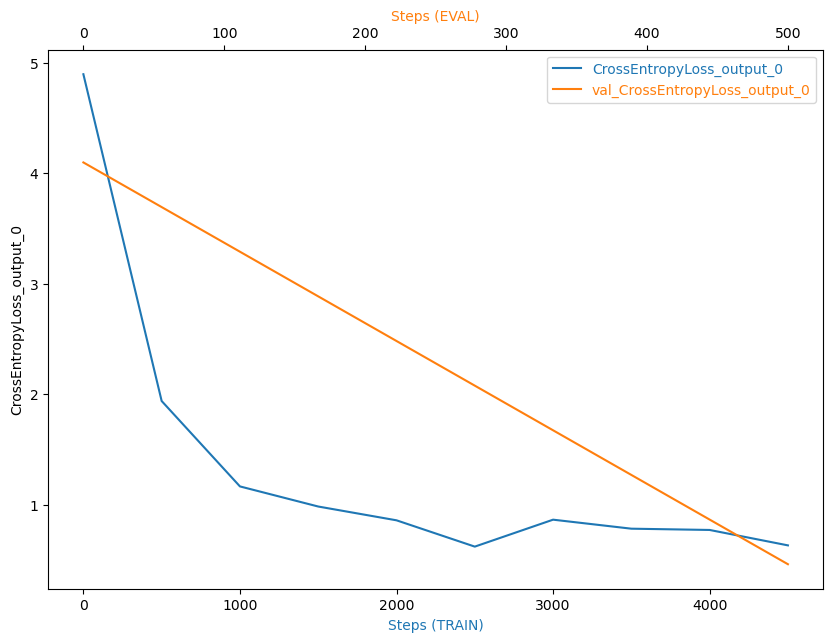

In [23]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [24]:
tj = TrainingJob(job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-151577940819/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-151577940819/pytorch-training-2023-08-11-14-19-05-642/profiler-output


Profiler data from system is available


In [25]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-151577940819/pytorch-training-2023-08-11-14-19-05-642/rule-output


In [26]:
! aws s3 ls {rule_output_path} --recursive

2023-08-11 15:44:05     462951 pytorch-training-2023-08-11-14-19-05-642/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-08-11 15:44:05     326621 pytorch-training-2023-08-11-14-19-05-642/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-08-11 15:43:59        568 pytorch-training-2023-08-11-14-19-05-642/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-08-11 15:43:59     265417 pytorch-training-2023-08-11-14-19-05-642/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-08-11 15:43:59       1941 pytorch-training-2023-08-11-14-19-05-642/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-08-11 15:43:59        325 pytorch-training-2023-08-11-14-19-05-642/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-08-11 15:43:59       4909 pytorch-training-2023-08-11-14-19-05-642/rule-output/ProfilerReport/profiler-output/profiler-re

In [27]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-151577940819/pytorch-training-2023-08-11-14-19-05-642/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-151577940819/pytorch-training-2023-08-11-14-19-05-642/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-151577940819/pytorch-training-2023-08-11-14-19-05-642/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-151577940819/pytorch-training-2023-08-11-14-19-05-642/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallSystemUsage.json to ProfilerReport/profiler-output/profiler-reports/OverallSystemUsage.json
download: s3://sagemaker-us-east-1-151577940819/pytorch-training-2023-08-11-14-19-05-642/rule-output/Pro

In [28]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [29]:
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [30]:
model_data = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model: {model_data}")

Model: s3://sagemaker-us-east-1-151577940819/pytorch-training-2023-08-11-14-19-05-642/output/model.tar.gz


In [5]:
model_data = "s3://sagemaker-us-east-1-151577940819/pytorch-training-2023-08-11-14-19-05-642/output/model.tar.gz"

In [6]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [46]:
hyper = dict()

hyper["layers"] = hyperparameters["layers"]

hyper["layers"] = list() if len(hyper["layers"])==0 else list(map(int,hyper["layers"].split(" ")))

hyper["model_name"] = hyperparameters["model-name"]

hyper["num_classes"] = 133

with open("inference_template.py","r") as f:
    raws=f.readlines()

i=raws.index("JPEG_CONTENT_TYPE = 'image/jpeg'\n")

ch="hyperparameters={}\n".format(str(hyper))

raws.insert(i+2,ch)
    
with open("inference.py","w") as f:
    f.writelines(raws)

In [7]:
pytorch_model = PyTorchModel(
    model_data=model_data, 
    role=role, 
    entry_point='inference.py',
    py_version="py36",
    framework_version="1.8",
    predictor_cls=ImagePredictor
)


In [8]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large') 

-----!

In [9]:
with open("./dogImages/valid/126.Saint_bernard/Saint_bernard_08033.jpg", "rb") as f:
    image = f.read() 

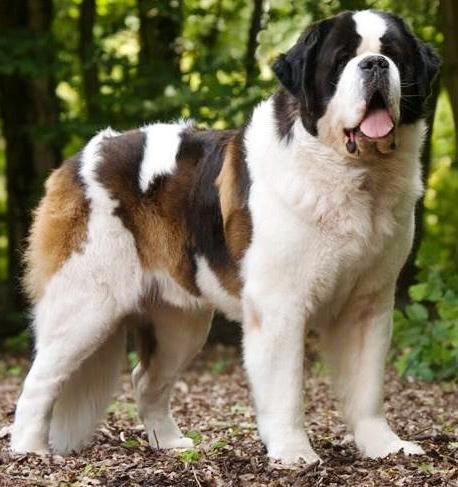

In [39]:
Image.open(io.BytesIO(image))

In [10]:
response = predictor.predict(image , initial_args={"ContentType": "image/jpeg"})

In [11]:
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(1,134), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

Raw prediction result:
[[-8.884904861450195, -9.279474258422852, -8.513564109802246, 0.002981085330247879, -1.8007665872573853, -8.0718412399292, -6.871734619140625, -4.199583053588867, -7.9256205558776855, -2.807870626449585, -7.429387092590332, -1.185996651649475, -12.133108139038086, -9.469078063964844, -6.197041034698486, -6.600386619567871, -5.175547122955322, -11.328082084655762, -10.786568641662598, -11.29114055633545, -11.579835891723633, -10.131567001342773, -1.0865191221237183, -7.5730299949646, -14.463398933410645, -7.731719970703125, -10.93433666229248, -9.899015426635742, -3.180751085281372, -10.297357559204102, -3.6271190643310547, -3.908599853515625, -6.563141822814941, -6.494313716888428, -9.705442428588867, -8.836649894714355, -2.4501867294311523, -9.649810791015625, -7.593615531921387, -2.4304869174957275, -7.372565746307373, -10.12872314453125, -4.635753631591797, -6.180297374725342, -4.337512969970703, -3.042227268218994, -8.456047058105469, -8.731010437011719, -11.

In [12]:
predictor.delete_endpoint()